# Linear Regression

From dataset, predict life expectancy of different countries during different years given different socioeconomic features

In [ ]:
import pandas as pd
import io
from google.colab import files

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV,  Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.genmod.generalized_linear_model import GLM
import statsmodels.api as sm # from vizualization techniques and plotting

import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error # predicted vs actual values
from yellowbrick.regressor import AlphaSelection # for cross-validation

In [ ]:
uploaded = files.upload()

Saving LifeExpectancy.csv to LifeExpectancy.csv


In [ ]:
life_expectancy_data = pd.read_csv('LifeExpectancy.csv',index_col=[0])

In [ ]:
life_expectancy_data.head()
#life_expectancy_data.shape

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


##Preprocessing

In [ ]:
# get the missing values
life_expectancy_data.isna().sum().sort_values(ascending=False)

,0
population,652
hepatitis_b,553
gdp,448
total_expenditure,226
alcohol,194
income_composition_of_resources,167
schooling,163
thinness_5_9_years,34
thinness__1_19_years,34
bmi,34


In [ ]:
# get categorical variables
categorical_columns = list(life_expectancy_data.dtypes[life_expectancy_data.dtypes=='O'].index.values) # 'O' means object
#print(categorical_columns)

for column in categorical_columns:
  life_expectancy_data[column] = life_expectancy_data[column].astype('category')

life_expectancy_data.head()

,country,year,status,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


####Dataset partition

In [ ]:
# pour all features/columns that dont contain a particular column
X = life_expectancy_data.loc[:,life_expectancy_data.columns != 'life_expectancy'] # dataset to train the model
#X.head()
y = life_expectancy_data['life_expectancy'] #response variable
#y.head()

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42) #

In [ ]:
X_train.shape, y_train.shape

((1968, 21), (1968,))

####Applying preprocessing

In [ ]:
print(categorical_columns)

['country', 'status']


In [ ]:
def minimum_preprocessing(X,y):
  print('Original Size:{}'.format(X.shape))
  categorical_columns = X.dtypes[X.dtypes == 'category'].index.values
  # Remove categorical variables
  X = X.drop(columns=categorical_columns)
  print('Removed: {}'.format(categorical_columns))

  # Remove missing values - means to eliminate rows
  X = X.dropna()
  y= y[X.index] # somehow this is the way to make the same as of y as X after drop
  print('New Size: {}'.format(X.shape))
  return X,y

In [ ]:
X_train, y_train = minimum_preprocessing(X_train, y_train)
X_test, y_test = minimum_preprocessing(X_test, y_test)

Original Size:(1968, 21)
Removed: ['country' 'status']
New Size: (1123, 19)
Original Size:(970, 21)
Removed: ['country' 'status']
New Size: (526, 19)


##Implementation


Scikit-learn

In [ ]:
# instantiate
linear_reg = LinearRegression()
# training process - fit data with fit method
linear_reg.fit(X_train, y_train)
#prediction
y_pred = linear_reg.predict(X_train)


In [ ]:
y_train.head()

,life_expectancy
2285,72.6
601,63.0
360,73.3
1616,78.0
303,62.0


In [ ]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df.head()

,0
0,71.490100
1,64.136799
2,74.087534
3,69.605914
4,55.889884


In [ ]:
weights = linear_reg.coef_
intercept = linear_reg.intercept_

print('coefficients: \n', weights[:10])
print('Interceptor: \n', intercept)
#weights.shape

coefficients: 
 [-1.38838510e-01 -1.64718849e-02  9.84951481e-02 -1.15513163e-01
  3.10980998e-04 -3.96311344e-03 -1.99845930e-05  2.64062644e-02
 -7.16892511e-02  1.37560599e-03]
Interceptor: 
 331.80563868621994


Statsmodels - linear regression is called ordinary least squares(OLS) in statsmodels

In [ ]:
model = sm.OLS(y_train, sm.add_constant(X_train)) #
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        life_expectancy   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     281.4
Date:                Wed, 25 Sep 2024   Prob (F-statistic):               0.00
Time:                        09:17:21   Log-Likelihood:                -3054.1
No. Observations:                1123   AIC:                             6148.
Df Residuals:                    1103   BIC:                             6249.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                             331.8056     58.609      5.661      0.000     216.808     446.803
year                               -0.1388      0.029     -4.744      0.000      -0.196      -0.081
adult_mortality                    -0.0165      0.001    -13.942      0.000      -0.019      -0.014
infant_deaths                       0.0985      0.014      6.915      0.000       0.071       0.126
alcohol                            -0.1155      0.040     -2.916      0.004      -0.193      -0.038
percentage_expenditure              0.0003      0.000      1.113      0.266      -0.000       0.001
hepatitis_b                        -0.0040      0.006     -0.700      0.484      -0.015       0.007
measles                         -1.998e-05   1.49e-05     -1.344      0.179   -4.92e-05    9.18e-06
bmi                                 0.0264      0.008      3.466      0.001       0.011       0.041
under_five_deaths                  -0.0717      0.010     -7.065      0.000      -0.092      -0.052
polio                               0.0014      0.006      0.214      0.831      -0.011       0.014
total_expenditure                   0.0595      0.050      1.178      0.239      -0.040       0.159
diphtheria                          0.0144      0.007      1.933      0.054      -0.000       0.029
hiv_aids                           -0.4456      0.022    -20.234      0.000      -0.489      -0.402
gdp                              2.718e-05   4.47e-05      0.609      0.543   -6.04e-05       0.000
population                      -3.213e-09    2.7e-09     -1.191      0.234   -8.51e-09    2.08e-09
thinness__1_19_years               -0.0127      0.065     -0.196      0.844      -0.140       0.114
thinness_5_9_years                 -0.0831      0.064     -1.290      0.197      -0.209       0.043
income_composition_of_resources    10.6726      1.025     10.413      0.000       8.662      12.684
schooling                           0.9519      0.075     12.707      0.000       0.805       1.099
==============================================================================
Omnibus:                       24.164   Durbin-Watson:                   2.066
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.518
Skew:                          -0.113   Prob(JB):                     2.15e-10
Kurtosis:                       3.949   Cond. No.                     3.02e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.02e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

###Analysis of the model

<Axes: ylabel='Density'>

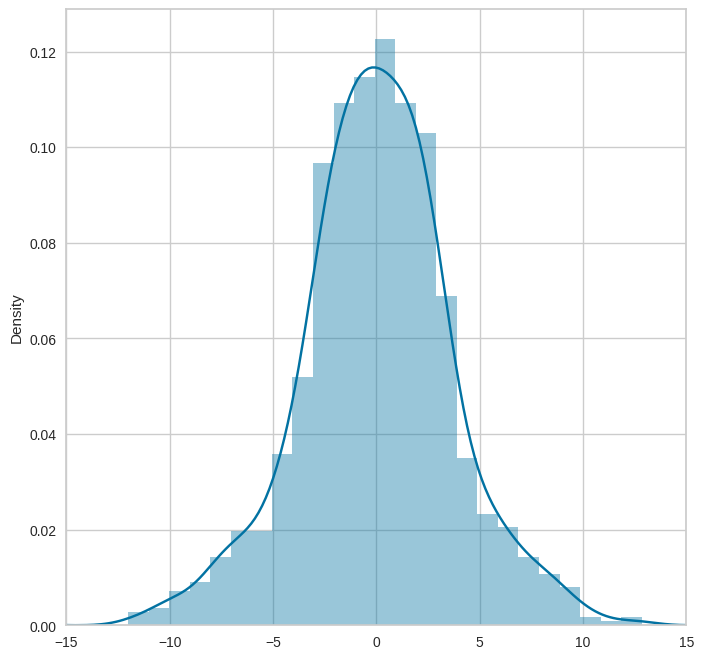

In [ ]:
#plot residuals of training data to verify distribution
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim([-15,15])
sns.distplot(result.resid,bins=30)

((array([-3.23088511, -2.96820298, -2.82177751, ...,  2.82177751,
          2.96820298,  3.23088511]),
  array([-16.98607418, -12.01105412, -11.33471521, ...,  11.07616836,
          12.36369399,  12.83749939])),
 (3.6616205785793308, 3.7896709234638947e-10, 0.9947688098690366))

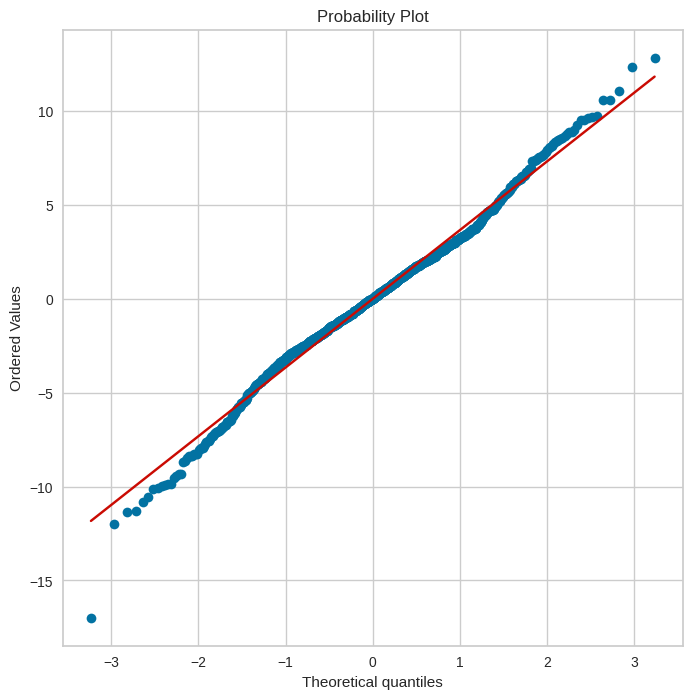

In [ ]:
#also with probability plot to check distribution of train dataset residuals
fig, ax = plt.subplots(figsize=(8,8))
stats.probplot(result.resid, plot=plt)


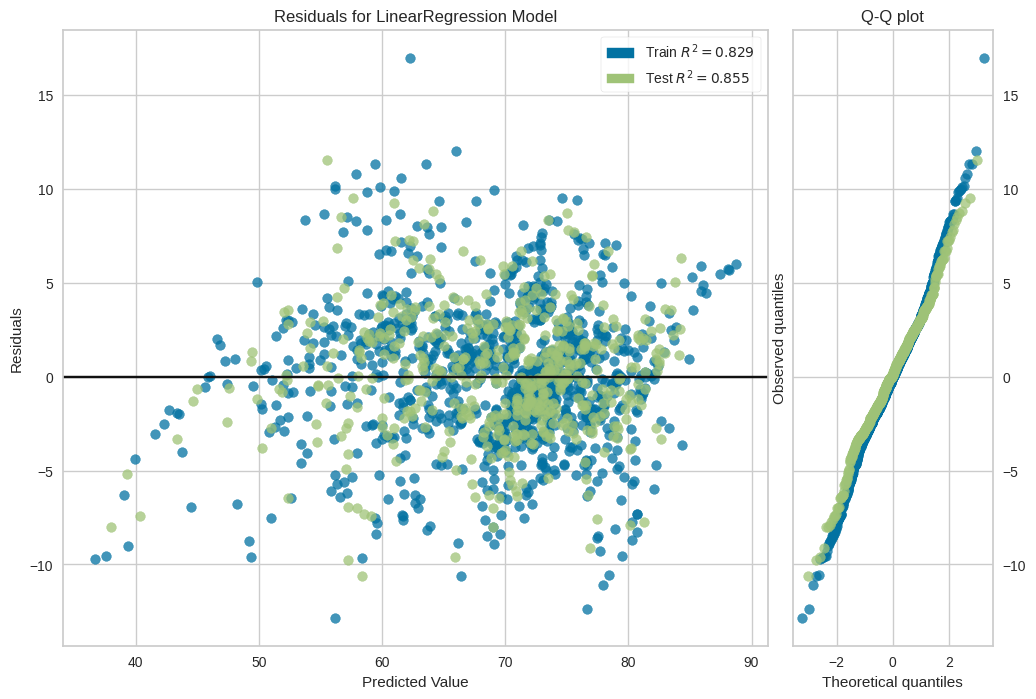

In [ ]:
# QQ plot - check residual distribution of two datasets ( this case train & test)
plt.figure(figsize=(12,8))
viz = residuals_plot(linear_reg, X_train, y_train, X_test, y_test, is_fitter=True,qqplot=True, hist=False)

Visualize predicted values to actual values

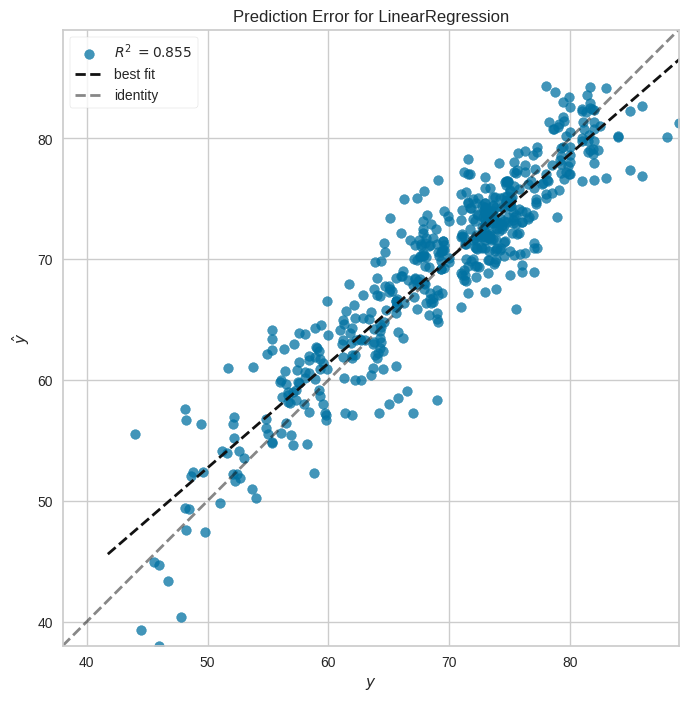

In [ ]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(linear_reg, X_test, y_test, is_fitted = True)

##Metrics

MSE

In [ ]:


N = X_train.shape[0]

# using statsmodel

prediction = result.predict(sm.add_constant(X_train))
MSE_sm = np.sum((y_train-prediction)**2)/N

# using sklearn
MSE_sk = mean_squared_error(y_train, prediction)

MSE_sm, MSE_sk


(13.480918067442284, 13.480918067442284)

Normalized MSE

In [ ]:
norm_MSE_sm = np.sum((y_train-prediction)**2)/((N)*np.var(y_train))
norm_MSE_sm

0.17104150205288332

R-Squared

In [ ]:
R_squared_sm = 1 - norm_MSE_sm

R_squared_sk = r2_score(y_train, prediction)

R_squared_sm, R_squared_sk

(0.8289584979471167, 0.8289584979471166)

##Cross-validation

In [ ]:
# k-fold method
cross_val_metrics = pd.DataFrame(columns=['MSE','norm_MSE','R2'])

kf = KFold(n_splits=5)
i = 1
for train_index, test_index in kf.split(X_train):
  print('Split {}:\n\tTest Folds: [{}]  \n\tTrain Folds: {}'.format(i, i,[j for j in range(1,6) if j !=i]))
  x_train_fold = X_train.values[train_index]
  y_train_fold = y_train.values[train_index]
  x_test_fold = X_train.values[test_index,:]
  y_test_fold = y_train.values[test_index]

  linear_reg = LinearRegression().fit(x_train_fold, y_train_fold)
  y_pred_fold = linear_reg.predict(x_test_fold)
  fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
  fold_nmse = 1 - r2_score(y_test_fold, y_pred_fold)
  fold_r2 = r2_score(y_test_fold, y_pred_fold)

  print(f'\tMSE: {fold_mse:3.3f} NMSE: {fold_nmse:3.3f} R2: {fold_r2:3.3f}')
  cross_val_metrics.loc[f'Fold {i}', :] = [fold_mse, fold_nmse, fold_r2]
  i=i+1

Split 1:
	Test Folds: [1]  
	Train Folds: [2, 3, 4, 5]
	MSE: 15.126 NMSE: 0.156 R2: 0.844
Split 2:
	Test Folds: [2]  
	Train Folds: [1, 3, 4, 5]
	MSE: 12.915 NMSE: 0.186 R2: 0.814
Split 3:
	Test Folds: [3]  
	Train Folds: [1, 2, 4, 5]
	MSE: 15.121 NMSE: 0.205 R2: 0.795
Split 4:
	Test Folds: [4]  
	Train Folds: [1, 2, 3, 5]
	MSE: 13.265 NMSE: 0.170 R2: 0.830
Split 5:
	Test Folds: [5]  
	Train Folds: [1, 2, 3, 4]
	MSE: 13.932 NMSE: 0.189 R2: 0.811


In [ ]:
linear_reg.coef_

array([-1.39524653e-01, -1.54975687e-02,  9.51449784e-02, -1.16825172e-01,
        2.38781985e-04, -8.13348509e-03, -2.15713430e-05,  3.01184942e-02,
       -6.93106487e-02,  3.35078766e-03,  5.52936128e-02,  1.47027639e-02,
       -4.41727132e-01,  3.75346264e-05, -3.45272910e-09, -5.53916816e-02,
       -2.16091756e-02,  1.14277046e+01,  9.24869384e-01])

In [ ]:
cross_val_metrics.loc['Mean',:] = cross_val_metrics.mean()
cross_val_metrics

,MSE,norm_MSE,R2
Fold 1,15.125774,0.156393,0.843607
Fold 2,12.915315,0.185853,0.814147
Fold 3,15.1209,0.205437,0.794563
Fold 4,13.264579,0.169535,0.830465
Fold 5,13.932224,0.189038,0.810962
Mean,14.071759,0.181251,0.818749


#Ridge regression

In [ ]:
ridge_cross_val_metrics = pd.DataFrame(columns=['mean MSE','mean norm_MSE','mean R2'])
lambdas = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 10,50,100]
# calculate cross-validation metrics for each lambda
for lambda_val in lambdas:
  kf = KFold(n_splits=5)
  cv_mse = []
  cv_nmse = []
  cv_r2 = []
  # calculate the metric for each partition and average
  for train_index, test_index in kf.split(X_train):
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]

    lin_reg = Ridge(alpha=lambda_val).fit(x_train_fold, y_train_fold)
    y_pred_fold = lin_reg.predict(x_test_fold)
    fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse = 1 - r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)

    cv_mse.append(fold_mse)
    cv_nmse.append(fold_nmse)
    cv_r2.append(fold_r2)

  ridge_cross_val_metrics.loc[f'Lambda {lambda_val}', :] = [np.mean(cv_mse), np.mean(cv_nmse), np.mean(cv_r2)]

ridge_cross_val_metrics.sort_values(by='mean R2', ascending=False)

,mean MSE,mean norm_MSE,mean R2
Lambda 0.0001,14.071758,0.181251,0.818749
Lambda 0.001,14.071758,0.181251,0.818749
Lambda 0.01,14.071756,0.181252,0.818748
Lambda 0.1,14.071843,0.18126,0.81874
Lambda 0.5,14.074464,0.181321,0.818679
Lambda 1,14.081983,0.181449,0.818551
Lambda 10,14.396175,0.185775,0.814225
Lambda 50,14.990476,0.193647,0.806353
Lambda 100,15.172327,0.196051,0.803949


Used sklearn built-in implementation

In [ ]:
ridge_cv = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
print(f'Best Lambda:{ridge_cv.alpha_} R2 score: {ridge_cv.best_score_:3.3f}')

Best Lambda:0.0001 R2 score: 0.819


Visualize the Ridge regression

AlphaSelection(ax=<Axes: >,
               estimator=RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10,
                                         50, 100],
                                 store_cv_values=True))

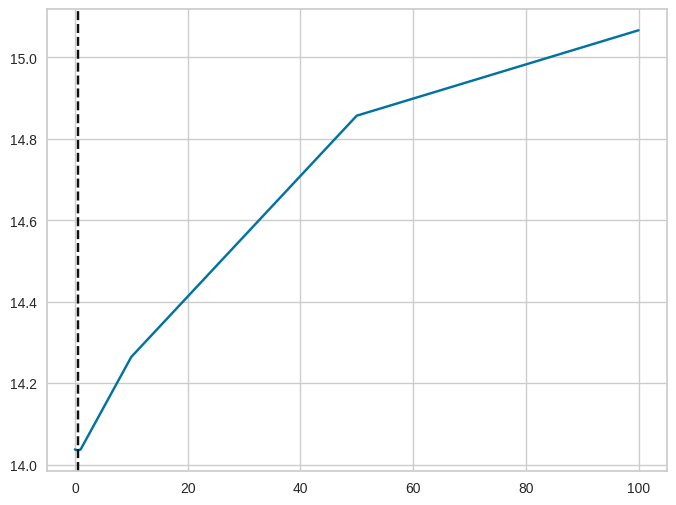

In [ ]:
plt.figure(figsize=(8,6))
visualization = AlphaSelection(RidgeCV(alphas=lambdas))
visualization.fit(X_train, y_train)

#Lasso regression

In [ ]:
lasso_cross_val_metrics = pd.DataFrame(columns=['mean MSE','mean norm_MSE','mean R2'])
lambdas = [1e-4, 1e-3, 1e-2, 0.1, 0.5, 1, 10,50,100]
# calculate cross-validation metrics for each lambda
for lambda_val in lambdas:
  kf = KFold(n_splits=5)
  cv_mse = []
  cv_nmse = []
  cv_r2 = []
  # calculate the metric for each partition and average
  for train_index, test_index in kf.split(X_train):
    x_train_fold = X_train.values[train_index]
    y_train_fold = y_train.values[train_index]
    x_test_fold = X_train.values[test_index,:]
    y_test_fold = y_train.values[test_index]

    lin_reg = Lasso(alpha=lambda_val).fit(x_train_fold, y_train_fold)
    y_pred_fold = lin_reg.predict(x_test_fold)
    fold_mse = mean_squared_error(y_test_fold, y_pred_fold)
    fold_nmse = 1 - r2_score(y_test_fold, y_pred_fold)
    fold_r2 = r2_score(y_test_fold, y_pred_fold)

    cv_mse.append(fold_mse)
    cv_nmse.append(fold_nmse)
    cv_r2.append(fold_r2)

  lasso_cross_val_metrics.loc[f'Lambda {lambda_val}', :] = [np.mean(cv_mse), np.mean(cv_nmse), np.mean(cv_r2)]

lasso_cross_val_metrics.sort_values(by='mean R2', ascending=False)

,mean MSE,mean norm_MSE,mean R2
Lambda 0.0001,14.071001,0.181243,0.818757
Lambda 0.001,14.071103,0.18125,0.81875
Lambda 0.01,14.081084,0.181434,0.818566
Lambda 0.1,14.981729,0.193612,0.806388
Lambda 0.5,15.466179,0.199951,0.800049
Lambda 1,15.782087,0.204088,0.795912
Lambda 10,27.700223,0.358199,0.641801
Lambda 50,34.335762,0.441817,0.558183
Lambda 100,35.603493,0.458169,0.541831


In [ ]:
# Used sklearn built-in implementation
lasso_cv = LassoCV(alphas=lambdas, cv=5).fit(X_train, y_train)
# best score doesnt exist for LassoCV
lasso_r2 = np.mean(cross_val_score(lasso_cv, X_train, y_train))
print('Best Lambda: ', lasso_cv.alpha_, 'R2 score: ', round(lasso_r2,5))


Best Lambda:  0.0001 R2 score:  0.81879


AlphaSelection(ax=<Axes: >,
               estimator=LassoCV(alphas=[0.0001, 0.001, 0.01, 0.1, 0.5, 1, 10,
                                         50, 100]))

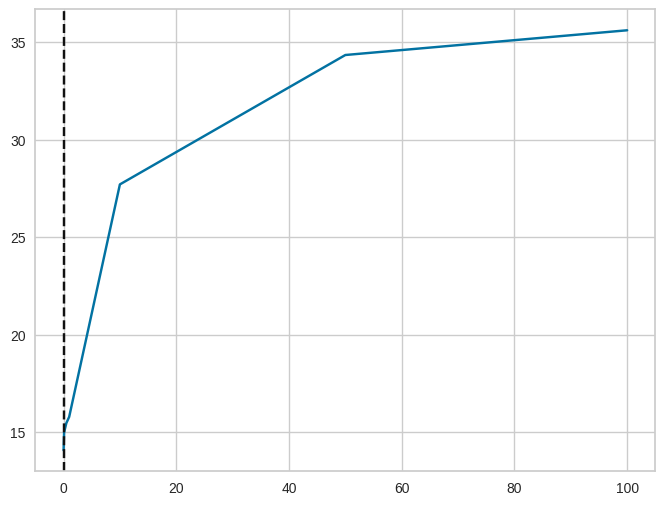

In [ ]:
plt.figure(figsize=(8,6))
visualization = AlphaSelection(LassoCV(alphas=lambdas))
visualization.fit(X_train, y_train)

Compare regression methods

Linear:0.818749

Lasso:0.818749

Ridge:0.818757

# Understanding models

In [ ]:
# arraay of weights estimated by regression
weights = pd.DataFrame({'lr':linear_reg.coef_,'ridge_cv':ridge_cv.coef_,'lasso_cv':lasso_cv.coef_}, index=X_train.columns)
weights.T

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
lr,-0.139525,-0.015498,0.095145,-0.116825,0.000239,-0.008133,-0.000022,0.030118,-0.069311,0.003351,0.055294,0.014703,-0.441727,0.000038,-3.452729e-09,-0.055392,-0.021609,11.427705,0.924869
ridge_cv,-0.138838,-0.016472,0.098495,-0.115513,0.000311,-0.003963,-0.000020,0.026406,-0.071689,0.001376,0.059479,0.014371,-0.445590,0.000027,-3.213065e-09,-0.012716,-0.083056,10.672488,0.951866
lasso_cv,-0.138889,-0.016477,0.098064,-0.115649,0.000311,-0.003960,-0.000020,0.026421,-0.071384,0.001380,0.059418,0.014391,-0.445613,0.000027,-3.189663e-09,-0.012702,-0.082981,10.667550,0.952170


Note: The weights of linear regression are different than the ones in tutorial

<Axes: >

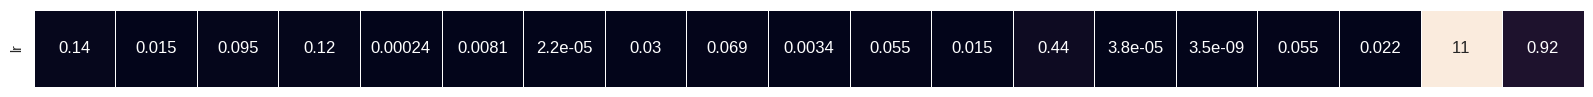

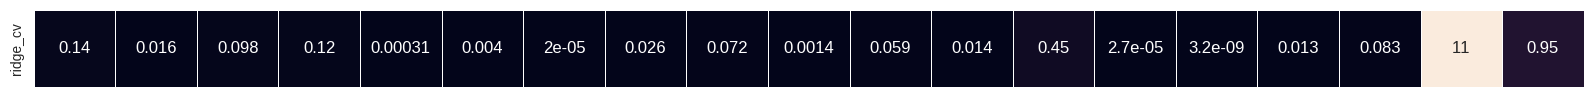

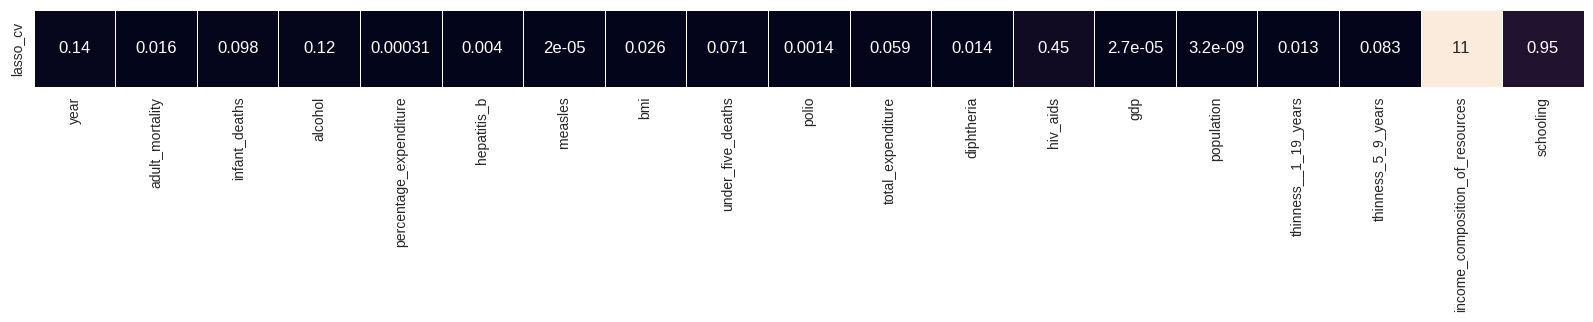

In [ ]:
# visualization

fig, ax = plt.subplots(figsize=(20,1))
sns.heatmap(weights.T.loc[['lr'],:].abs(), annot=True, linewidth=0.5, ax=ax, cbar=False, xticklabels=False)
plt.figure(figsize=(20,1))
sns.heatmap(weights.T.loc[['ridge_cv'],:].abs(), annot=True, linewidth=0.5, cbar=False, xticklabels=False)
plt.figure(figsize=(20,1))
sns.heatmap(weights.T.loc[['lasso_cv'],:].abs(), annot=True, linewidth=0.5, cbar=False, xticklabels=True)

<Axes: >

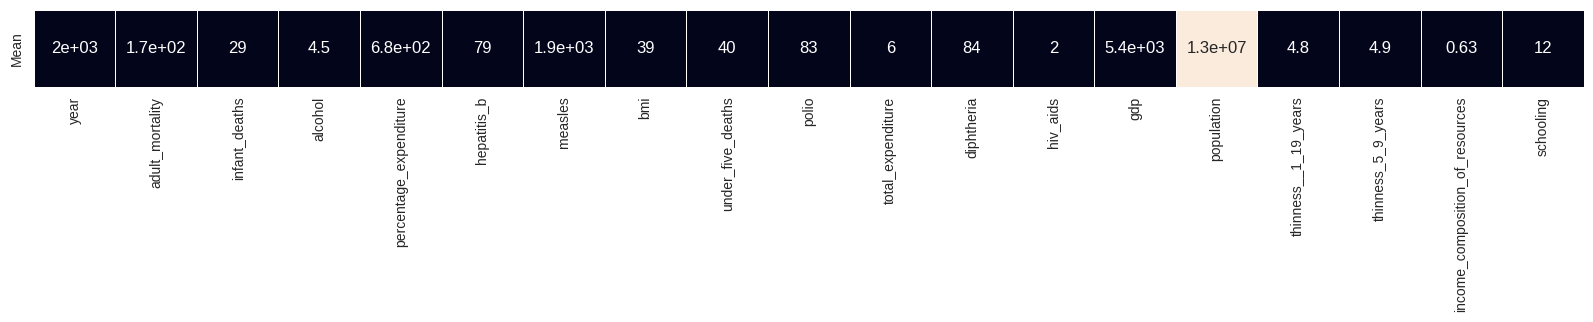

In [ ]:
# comparing weights to mean values of variables, results in linear regression trying to balance the range of variables => scaling data
plt.figure(figsize=(20,1))
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}), annot=True, linewidth=0.5, cbar=False, xticklabels=True)

##Scaling data

In [ ]:
def scaling_preprocessing(X,y, scaler=None):
  print('Original Size:{}'.format(X.shape))
  categorical = X.dtypes[X.dtypes=='category'].index.values
  #scale numerical variables
  numerical = [c for c in X.columns if c not in categorical]
  if scaler is None:
    scaler = MinMaxScaler() # default 0-1
    X[numerical] = scaler.fit_transform(X[numerical])
  else:
    X[numerical] = scaler.fit_transform(X[numerical])

  # eliminate categorical variables
  X = X.drop(columns=categorical)
  print('Removed: {}'.format(categorical_columns))

  # eliminate missing values
  X = X.dropna()
  y= y[X.index]
  print('New Size: {}'.format(X.shape))
  return X, y, scaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
X_train, y_train, scaler = scaling_preprocessing(X_train, y_train)
X_test, y_test, _ = scaling_preprocessing(X_test, y_test, scaler)

Original Size:(1968, 21)
Removed: ['country', 'status']
New Size: (1123, 19)
Original Size:(970, 21)
Removed: ['country', 'status']
New Size: (526, 19)


In [ ]:
X_train.describe()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
count,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000,1123.000000
mean,0.520570,0.230624,0.016183,0.261963,0.035808,0.800362,0.008914,0.433462,0.015981,0.834780,0.322140,0.843635,0.038488,0.046808,0.010826,0.170558,0.167396,0.666777,0.593237
std,0.272906,0.174030,0.059487,0.234418,0.091423,0.258102,0.043018,0.230014,0.058671,0.240660,0.139528,0.228308,0.122311,0.096813,0.047011,0.164190,0.160096,0.194119,0.134609
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.010204,0.000000,0.006985,0.000000,0.010417,0.005438,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.214634
25%,0.333333,0.105263,0.000556,0.038150,0.001934,0.755102,0.000000,0.214203,0.000400,0.812500,0.230816,0.824742,0.000000,0.004026,0.000162,0.054348,0.056140,0.542194,0.507317
50%,0.533333,0.202216,0.001667,0.218497,0.007836,0.897959,0.000071,0.500582,0.001600,0.927083,0.314804,0.927835,0.000000,0.014194,0.001203,0.101449,0.105263,0.712025,0.600000
75%,0.733333,0.310249,0.011667,0.428035,0.026377,0.969388,0.001930,0.636787,0.010600,0.979167,0.414804,0.979381,0.011881,0.040820,0.006343,0.250000,0.242105,0.795359,0.682927
max,1.000000,1.000000,0.888889,1.000000,0.992790,1.000000,0.585433,0.881257,0.840000,1.000000,0.830211,1.000000,1.000000,1.000000,1.000000,0.981884,0.985965,0.987342,1.000000


<Axes: >

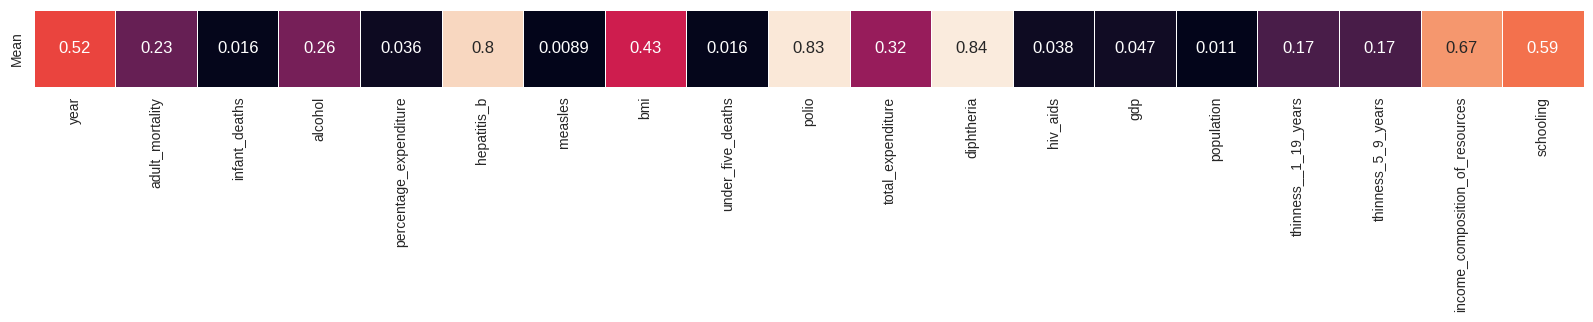

In [ ]:
plt.figure(figsize=(20,1))
sns.heatmap(X_train.mean().to_frame().T.rename(index={0:'Mean'}), annot=True, linewidth=0.5, cbar=False, xticklabels=True)

Performance after scaling

In [ ]:
lr_scaled = LinearRegression().fit(X_train, y_train)
r2_lr_scaled = np.mean(cross_val_score(lr_scaled, X_train, y_train, cv=5, scoring='r2'))

ridge_cv_scaled = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
r2_ridge_scaled = np.mean(cross_val_score(ridge_cv_scaled, X_train, y_train, cv=5, scoring='r2'))

lasso_cv_scaled = LassoCV(alphas=lambdas, cv=5).fit(X_train, y_train)
r2_lasso_scaled = np.mean(cross_val_score(lasso_cv_scaled, X_train, y_train, cv=5, scoring='r2'))

weights = pd.DataFrame({'lr scaled':lr_scaled.coef_,'ridge_cv scaled':ridge_cv_scaled.coef_,'lasso_cv scaled':lasso_cv_scaled.coef_}, index=X_train.columns)
weights.T

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
lr scaled,-2.082578,-11.892701,177.291267,-1.998378,5.939440,-0.388385,-4.240391,2.268298,-179.223128,0.132058,0.984384,1.393969,-22.502290,3.146725,-3.790387,-0.350968,-2.367096,10.117596,19.513204
ridge_cv scaled,-2.112440,-11.934102,161.825686,-2.082048,5.822061,-0.384108,-3.833752,2.272072,-163.923403,0.143106,0.979368,1.422363,-22.522237,3.259974,-3.300778,-0.341954,-2.337397,10.178690,19.551099
lasso_cv scaled,-2.100921,-11.925219,165.624351,-2.050803,5.849583,-0.379802,-3.848056,2.273515,-167.775716,0.138211,0.976616,1.410559,-22.512585,3.220908,-3.328747,-0.342757,-2.337941,10.162717,19.529276


In [ ]:
r2_results = pd.DataFrame({'lr ':r2_lr_scaled,'ridge_cv ':r2_ridge_scaled,'lasso_cv ':r2_lasso_scaled}, index=['CV R2'])
r2_results

,lr,ridge_cv,lasso_cv
CV R2,0.818749,0.818691,0.81883


##One-hot encoding

In [ ]:
X.head(5)

,country,year,status,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,...,polio,total_expenditure,diphtheria,hiv_aids,gdp,population,thinness__1_19_years,thinness_5_9_years,income_composition_of_resources,schooling
0,Afghanistan,2015,Developing,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
def categorical_preprocessing(X,y, scaler=None):
  print('Original Size:{}'.format(X.shape))
  categorical = X.dtypes[X.dtypes=='category'].index.values
  #scale numerical variables
  numerical = [c for c in X.columns if c not in categorical]
  if scaler is None:
    scaler = MinMaxScaler() # default 0-1
    X[numerical] = scaler.fit_transform(X[numerical])
  else:
    X[numerical] = scaler.fit_transform(X[numerical])

  # We apply one-hot encoding
  for column in categorical:
    X_one_hot = pd.get_dummies(X[column],prefix=column, dtype=int) # string to append dataframe column names
    X = X.merge(X_one_hot, left_index=True, right_index=True)
    X = X.drop(columns=column)

  # eliminate missing values
  X = X.dropna()
  y= y[X.index]
  print('New Size: {}'.format(X.shape))
  return X, y, scaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42)
X_train, y_train, scaler = categorical_preprocessing(X_train, y_train)
X_test, y_test, _ = categorical_preprocessing(X_test, y_test, scaler)

Original Size:(1968, 21)
New Size: (1123, 214)
Original Size:(970, 21)
New Size: (526, 214)


In [ ]:
X_train.head()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,...,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela (Bolivarian Republic of),country_Viet Nam,country_Yemen,country_Zambia,country_Zimbabwe,status_Developed,status_Developing
2285,0.733333,0.243767,0.000000,0.561272,0.058719,1.000000,0.000000,0.381839,0.0000,1.000000,...,0,0,0,0,0,0,0,0,0,1
601,0.400000,0.361496,0.001111,0.013873,0.004033,0.693878,0.000401,0.211874,0.0008,0.687500,...,0,0,0,0,0,0,0,0,0,1
360,0.466667,0.218837,0.036111,0.415029,0.020678,1.000000,0.000000,0.558789,0.0292,1.000000,...,0,0,0,0,0,0,0,0,0,1
1616,0.066667,0.177285,0.000000,0.113873,0.002163,0.989796,0.000000,0.165308,0.0000,0.979167,...,0,0,0,0,0,0,0,0,0,1
303,0.000000,0.430748,0.000556,0.009249,0.004888,0.989796,0.001970,0.145518,0.0004,0.989583,...,0,0,0,0,0,0,0,0,0,1


Performance after scaling + one hot

In [ ]:
lr_scaled_onehot = LinearRegression().fit(X_train, y_train)
r2_lr_train_onehot = lr_scaled_onehot.score(X_train, y_train)

r2_lr_onehot_cv = np.mean(cross_val_score(lr_scaled_onehot, X_train, y_train, cv=5, scoring='r2'))

print('Train R2 Score: {}\nCross-Validation R2 Score:{}'.format(r2_lr_train_onehot, r2_lr_onehot_cv))

Train R2 Score: 0.9662964545358765
Cross-Validation R2 Score:-7.796225139014858e+20


<Axes: >

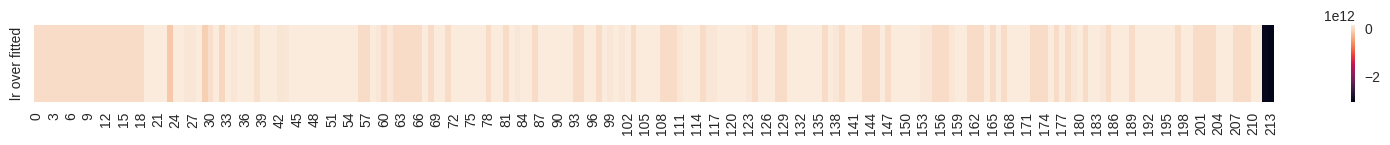

In [ ]:
plt.figure(figsize=(20,1))
sns.heatmap(pd.DataFrame({'lr over fitted': lr_scaled_onehot.coef_}).T)

## Regularization

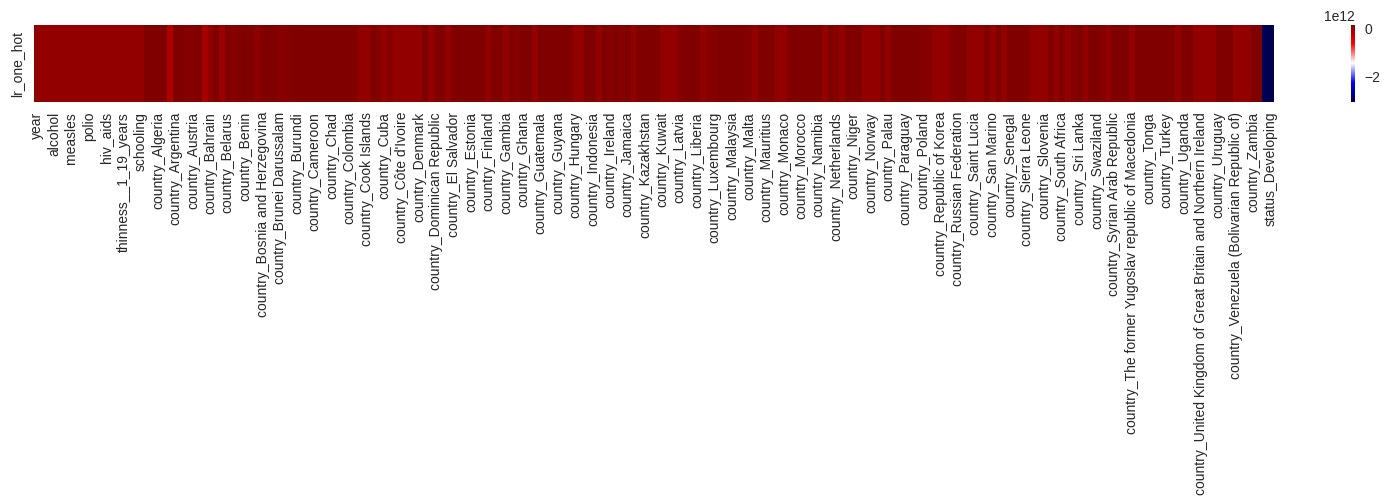

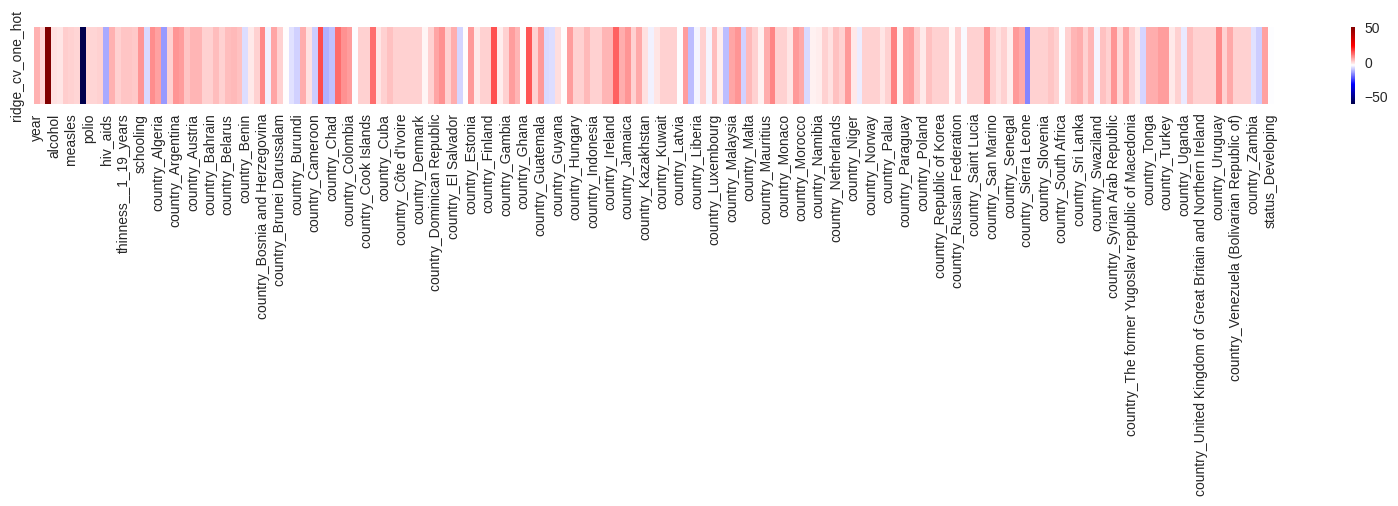

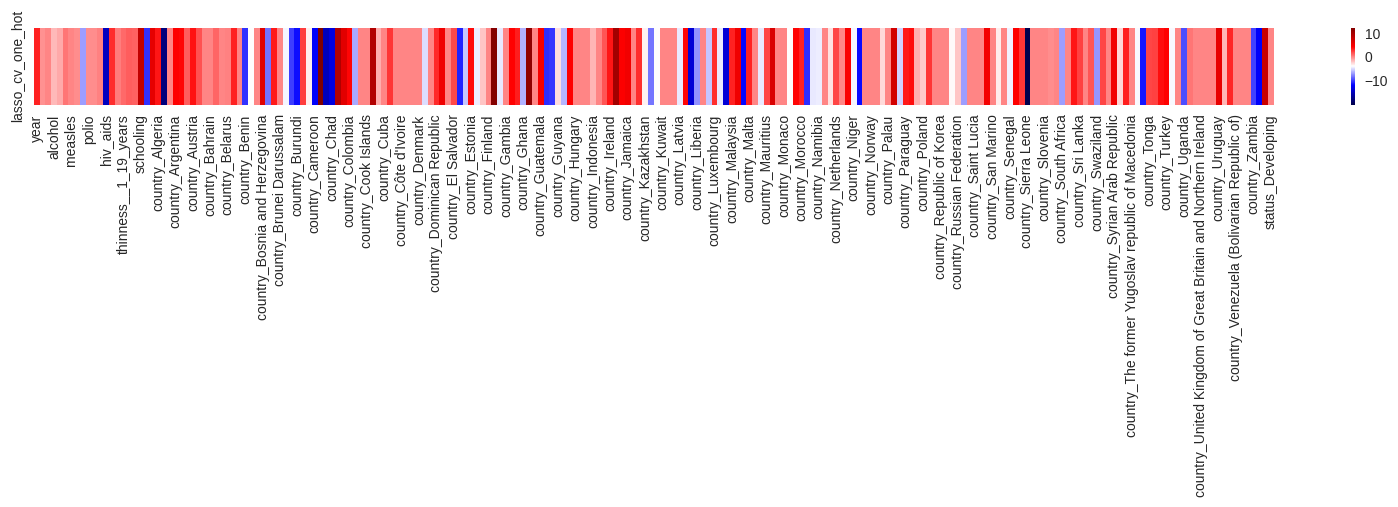

In [ ]:
# Ridge
ridge_onehot = RidgeCV(alphas=lambdas, cv=5).fit(X_train, y_train)
r2_ridge_train_onehot = ridge_onehot.score(X_train, y_train)
r2_ridge_onehot_cv = np.mean(cross_val_score(ridge_onehot, X_train, y_train, cv=5, scoring='r2'))

# Lasso
lasso_onehot = LassoCV(alphas=lambdas, cv=5).fit(X_train, y_train)
r2_lasso_train_onehot = lasso_onehot.score(X_train, y_train)
r2_lasso_onehot_cv = np.mean(cross_val_score(lasso_onehot, X_train, y_train, cv=5, scoring='r2'))

weights = pd.DataFrame(
    {
        'lr_one_hot': lr_scaled_onehot.coef_,
        'ridge_cv_one_hot': ridge_onehot.coef_,
        'lasso_cv_one_hot': lasso_onehot.coef_,
    },
    index = X_train.columns
)
for column in weights.columns:
  fig = plt.figure(figsize=(20,1))
  ax = sns.heatmap(weights[[column]].T, cmap='seismic')

In [ ]:
# results after regularization
r2_results.loc[:,'r2_lr_onehot_cv'] = r2_lr_onehot_cv
r2_results.loc[:,'r2_ridge_onehot_cv'] = r2_ridge_onehot_cv
r2_results.loc[:,'r2_lasso_onehot_cv'] = r2_lasso_onehot_cv

r2_results

,lr,ridge_cv,lasso_cv,r2_lr_onehot_cv,r2_ridge_onehot_cv,r2_lasso_onehot_cv
CV R2,0.818749,0.818691,0.81883,-7.796225e+20,0.950563,0.950555


## Final results

### Ridge

In [ ]:


y_test_predicted = ridge_onehot.predict(X_test)
r2_ridge = ridge_onehot.score(X_test, y_test)

print('Mean squared error with test data:{}'.format(mean_squared_error(y_test, y_test_predicted)))
print('Normalized MSE:{}'.format(1-r2_ridge))
print('R2 score with test data:{}'.format(r2_ridge))


Mean squared error with test data:2.5788647327781375
Normalized MSE:0.03478102846632758
R2 score with test data:0.9652189715336724


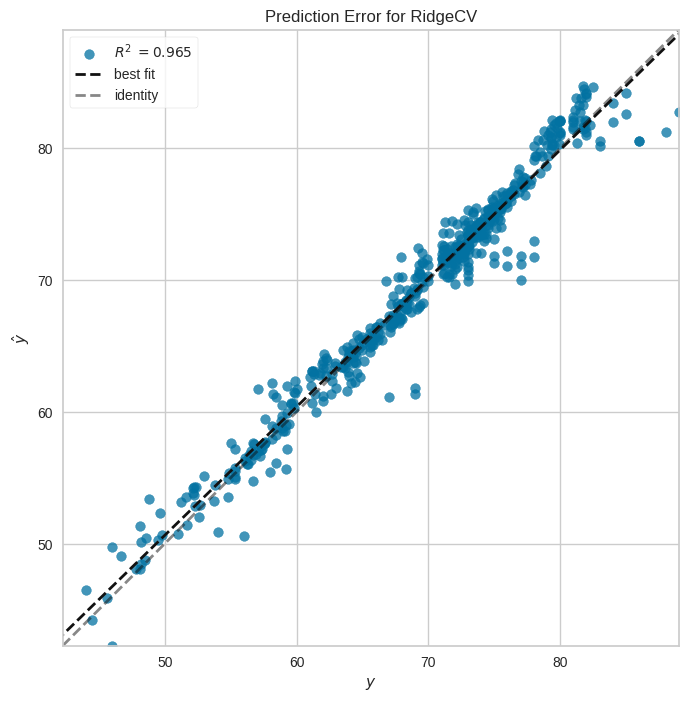

In [ ]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(ridge_onehot, X_test, y_test, is_fitted = True)

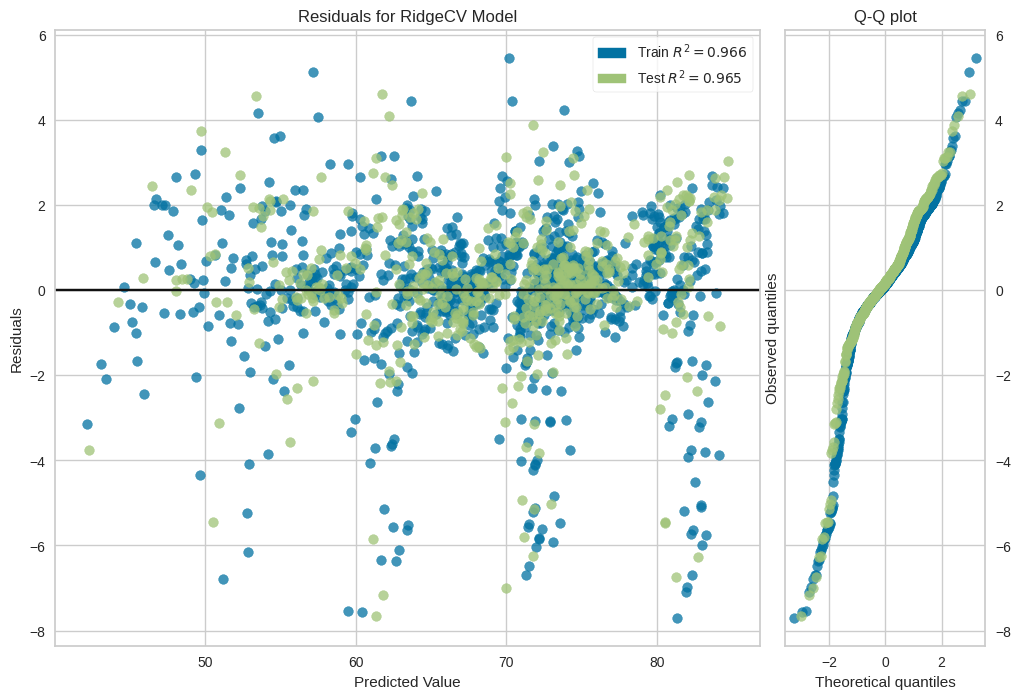

In [ ]:
# QQ plot
plt.figure(figsize=(12,8))
viz = residuals_plot(ridge_onehot, X_train, y_train, X_test, y_test, is_fitter=True,qqplot=True, hist=False)

### Lasso

In [ ]:


y_test_predicted = lasso_onehot.predict(X_test)
r2_lasso = lasso_onehot.score(X_test, y_test)

print('Mean squared error with test data:{}'.format(mean_squared_error(y_test, y_test_predicted)))
print('Normalized MSE:{}'.format(1-r2_lasso))
print('R2 score with test data:{}'.format(r2_lasso))


Mean squared error with test data:2.5857618131518807
Normalized MSE:0.034874049067898816
R2 score with test data:0.9651259509321012


In [ ]:
plt.figure(figsize=(8,8))
visualizer = prediction_error(lasso_onehot, X_test, y_test, is_fitted = True)

NameError: name 'plt' is not defined

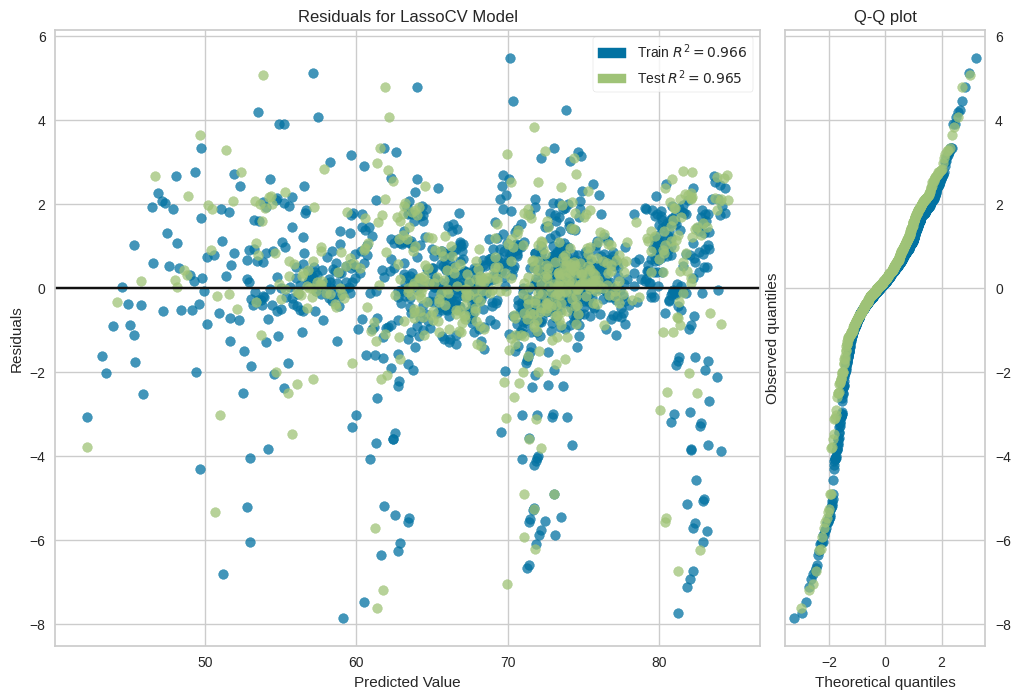

In [ ]:
# QQ plot
plt.figure(figsize=(12,8))
viz = residuals_plot(lasso_onehot, X_train, y_train, X_test, y_test, is_fitter=True,qqplot=True, hist=False)